In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import csv

In [2]:
def get_coordinates():
    while True:
        try:
            # Prompt user for latitude and longitude
            latitude = float(input("Enter the latitude (in decimal degrees): "))
            longitude = float(input("Enter the longitude (in decimal degrees): "))
            
            # Validate if the coordinates are within the bounds of Accra
            if 5.47 <= latitude <= 5.89 and -0.23 <= longitude <= -0.02:
                print(f"Coordinates ({latitude}, {longitude}) are valid for Accra.")
                return latitude, longitude
            else:
                print("Error: The coordinates are not within the valid range for Accra. Please try again.")
        except ValueError:
            print("Error: Please enter valid numeric values for latitude and longitude.")

# Get start and end coordinates from the user
start_lat, start_lon = get_coordinates()
end_lat, end_lon = get_coordinates()


Coordinates (5.583048098902002, -0.205963013039035) are valid for Accra.
Error: The coordinates are not within the valid range for Accra. Please try again.
Coordinates (5.640990116602893, -0.177423222460675) are valid for Accra.


In [3]:
# Load the healthcare facilities CSV file
health_facilities_df = pd.read_csv('../data/accra_facilities_filtered.csv')

# Convert the healthcare facilities DataFrame to a GeoDataFrame
health_facilities_gdf = gpd.GeoDataFrame(
    health_facilities_df, 
    geometry=gpd.points_from_xy(health_facilities_df.longitude, health_facilities_df.latitude)
)

# Load the no-fly zones and avoidance areas from GeoJSON files
no_fly_zones_gdf = gpd.read_file('../map/no_fly_zones.geojson')
avoidance_zones_gdf = gpd.read_file('../map/avoidance_zones.geojson')

In [4]:
# Define drone constraints
drone_range_km = 7  # Maximum range of the drone on a single charge
payload_capacity_kg = 2  # Maximum payload capacity of the drone

print(f"Drone constraints: Range = {drone_range_km} km, Payload Capacity = {payload_capacity_kg} kg")

Drone constraints: Range = 7 km, Payload Capacity = 2 kg


In [5]:
# Create an empty graph
G = nx.Graph()

# Add healthcare facilities as nodes
for idx, row in health_facilities_gdf.iterrows():
    G.add_node(idx, pos=(row['longitude'], row['latitude']))

# Function to add a new node to the graph
def add_node_to_graph(lat, lon, node_name):
    new_node_idx = len(G.nodes)  # New node index
    G.add_node(new_node_idx, pos=(lon, lat), name=node_name)
    
    # Connect this new node to existing nodes within range
    for idx, row in health_facilities_gdf.iterrows():
        distance = geodesic((lat, lon), (row['latitude'], row['longitude'])).km
        if distance <= drone_range_km:
            G.add_edge(new_node_idx, idx, weight=distance)
    
    return new_node_idx

# Add start and end coordinates as nodes if they are not in the graph
start_node = add_node_to_graph(start_lat, start_lon, 'Start')
end_node = add_node_to_graph(end_lat, end_lon, 'End')

# Add edges between existing nodes if they are within the drone's range
for i, row_i in health_facilities_gdf.iterrows():
    for j, row_j in health_facilities_gdf.iterrows():
        if i != j:
            distance = geodesic((row_i['latitude'], row_i['longitude']), (row_j['latitude'], row_j['longitude'])).km
            if distance <= drone_range_km:
                G.add_edge(i, j, weight=distance)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 299 nodes and 15088 edges.


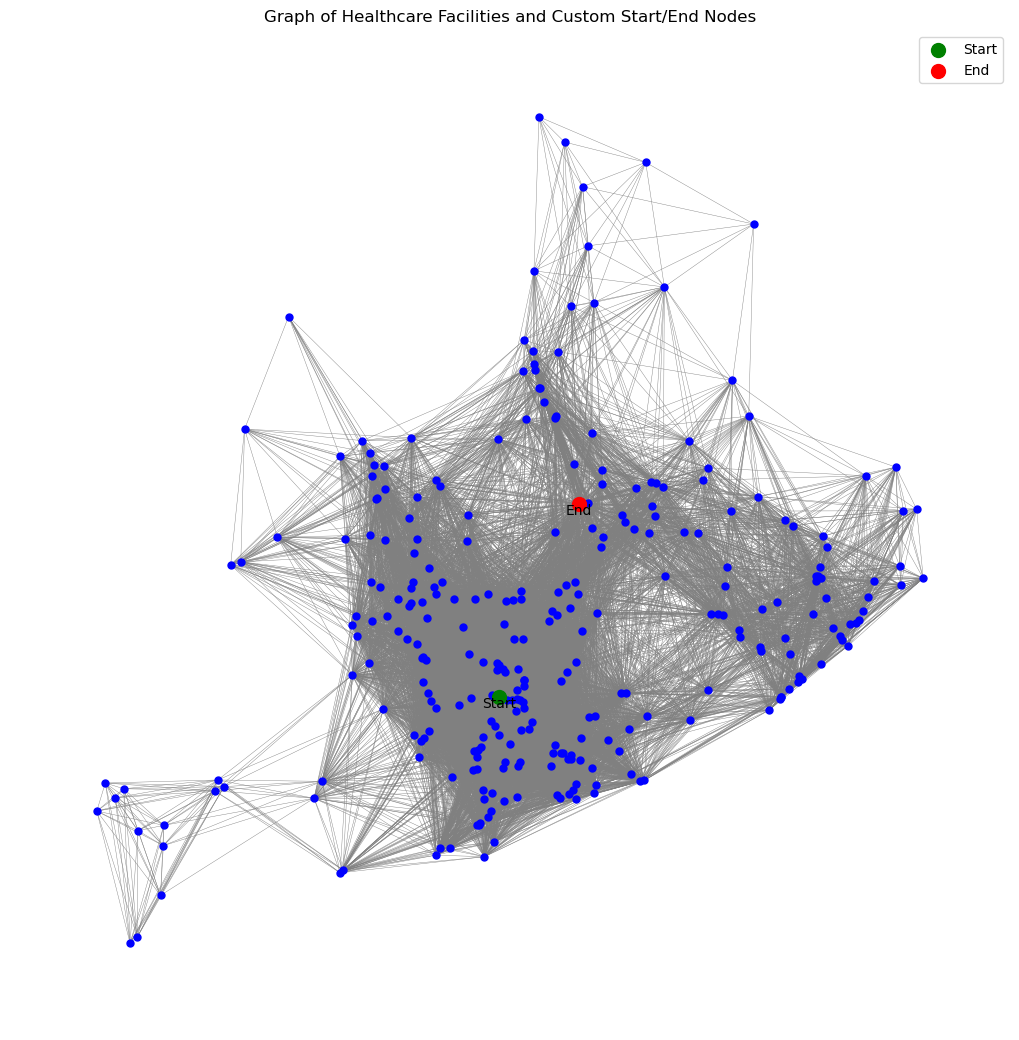

In [13]:
# Get the positions of the nodes for visualization
pos = nx.get_node_attributes(G, 'pos')

# Separate the custom start and end nodes from the healthcare facility nodes
facility_nodes = list(range(len(health_facilities_gdf)))  # Assuming facility nodes are indexed from 0 to len-1
custom_nodes = [start_node, end_node]  # Indices of start and end nodes

# Draw the main graph with healthcare facilities
plt.figure(figsize=(10, 5))
nx.draw(G, pos, nodelist=facility_nodes, node_size=25, node_color="blue", edge_color="gray", width=0.3, font_size=8)

# Draw the custom start and end nodes
nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color="green", node_size=100, label="Start")
nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color="red", node_size=100, label="End")

# Draw labels to the side of the nodes
nx.draw_networkx_labels(G, pos, labels={start_node: 'Start', end_node: 'End'}, font_size=10, font_color="black", verticalalignment='top')

plt.title("Graph of Healthcare Facilities and Custom Start/End Nodes")
plt.legend()
plt.show()


In [16]:
# Implement the A* algorithm
# We use the 'weight' attribute of the edges to find the shortest path by distance
try:
    shortest_path = nx.astar_path(G, start_node, end_node, weight='weight')
    print("Shortest path found:", shortest_path)
except nx.NetworkXNoPath:
    print("No path found between the start and end nodes.")

Shortest path found: [297, 166, 298]


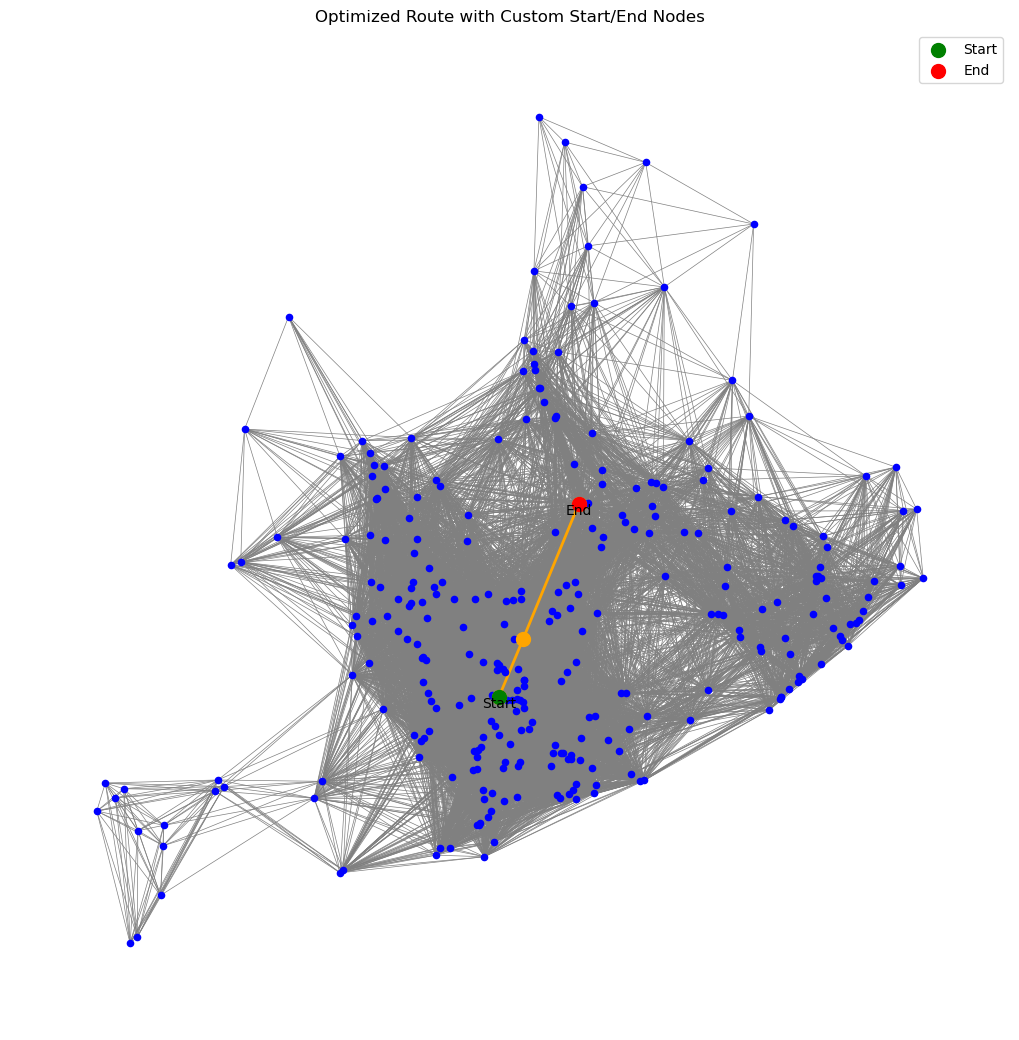

In [20]:
# Visualize the graph with the optimized route
plt.figure(figsize=(10, 10))
nx.draw(G, pos, nodelist=facility_nodes, node_size=20, node_color="blue", edge_color="gray", width=0.5, font_size=8)

# Highlight the optimized route
nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color="orange", node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=list(zip(shortest_path[:-1], shortest_path[1:])), edge_color="orange", width=2)

nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color="green", node_size=100, label="Start")
nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color="red", node_size=100, label="End")
nx.draw_networkx_labels(G, pos, labels={start_node: 'Start', end_node: 'End'}, font_size=10, font_color="black", verticalalignment='top')

plt.title("Optimized Route with Custom Start/End Nodes")
plt.legend()
plt.show()

In [25]:
# List to store the data for CSV
route_data = []

# Add start node
start_pos = pos[start_node]
route_data.append({
    "label": "Start",
    "lat": start_pos[1],
    "longitude": start_pos[0]
})

# Add charging stations (if any, i.e., intermediate nodes)
for node in shortest_path[1:-1]:
    node_pos = pos[node]
    route_data.append({
        "label": f"Charging Station {node}",
        "lat": node_pos[1],
        "longitude": node_pos[0]
    })

# Add end node
end_pos = pos[end_node]
route_data.append({
    "label": "End",
    "lat": end_pos[1],
    "longitude": end_pos[0]
})

# Define the CSV file path
csv_file_path = '../output/drone_route.csv'

# Write the data to a CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["label", "lat", "longitude"])
    writer.writeheader()
    writer.writerows(route_data)

print(f"Route data saved to {csv_file_path}")

Route data saved to ../output/drone_route.csv
